# Volatile Pheromone Field in Presence of Multiple Interacting Agents

In [73]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.animation as animation

Referenced: https://hplgit.github.io/fdm-book/doc/pub/book/sphinx/._book011.html

## Field Dynamics

The pheromone field follows $$\partial_t c(\vec{x}, t) = k_+ \rho_a(\vec{x},t) - k_-c + D \nabla^2 c$$ where:
- $ c(\vec{x}, t)$: is the concentration of the field at coordinates $\vec{x}$, at time $t$.
- $\rho_a(\vec{x},t)$: Gaussian Kernel convolved over the locations of the ant agents heading back.
- $k_+$: Generation constant
- $k_-$: Decay constant
- $D \ $:  Diffusion constant

### Non-Dimensional Quantities:
- $r$ = $v_a/k_-$ sets the length scale for the simulation.
- $\tau = r/v_a$ sets the timescale.
- The coordinates $\vec{x}$ can be expressed as $\vec{x} = (u\cdot r, v \cdot r) = r \cdot \vec{u}$; and time as $t = \hat{t}\tau$.

The field dynamics equation now becomes:
$$\frac{v_a}{r} \frac{\partial c}{\partial \hat{t}} = k_+ \rho_a - k_-c + \frac{D}{r^2} \nabla^2 c$$

$$ k_- \frac{\partial c}{\partial \hat{t}} = k_+ \rho_a - k_-c + \frac{k_-^2 D}{v_a^2} \nabla^2 c$$

$$\frac{\partial c}{\partial \hat{t}} = \frac{k_+}{k_-} \rho_a - c + \frac{k_- D}{v_a^2} \nabla^2 c$$

i.e.,

$$\frac{\partial c}{\partial \hat{t}} = \hat{k} \rho_a - c + \frac{1}{\text{P}} \nabla^2 c$$

$$$$
where $\quad \hat{k} = \frac{k_+}{k_-}$ (effective generation rate), $\quad \text{P} = \frac{k_- D}{v_a^2} = \frac{r v_a}{D}$ (the Peclet no.)

### Implicit Integration Scheme

In an implicit scheme, ignoring reinforcement:

$$c^{n+1} = c^n + \Delta \hat t(- c^{n+1} + \frac{1}{\text{P}}\nabla^2 c^{n+1})$$

and

$$(1+\Delta t) c^{n+1} - \frac{1}{\text{P}}\Delta t\nabla^2c^{n+1} = c^n$$

after discretizing field into a grid and ravelling it into a vector $\vec{c}^n$,

$$\left((1 +\Delta t) I - \frac{\Delta t}{\text{P}} L \right)\vec c^{n+1} = \vec c^n$$

where $I$ is the identity matrix of appropriate size and $L$ is the matrix that computes the approximate laplacian with finite differences.

This is of the form $\quad A \ \vec c^{n+1} = \vec c^n$

`scipy`'s linear eqn. solver can then be used to evaluate $c^{n+1}$ given $c^{n}$.

### In Presence of Pher. Generating Agents

The dynamics including the source term to account for the pheromones newly generated:

$$\frac{\vec c^{n+1}- \vec c^n}{\Delta \hat{t}} = \hat{k} \vec \rho_a^{n+1} - \vec c^{n+1} + \frac{1}{\text{P}} \nabla^2 \vec c^{n+1}$$

$$$$
$$\vec c^{n+1} = \vec c^n + \Delta \hat t \left(\hat{k} \vec \rho_a^{n+1} - \vec c^{n+1} + \frac{1}{\text{P}}\nabla^2 \vec c^{n+1}\right)$$

in the implicit scheme:

$$\left( (1 +\Delta \hat t ) I - \frac{\Delta \hat t}{\text{P}} L \right) \vec c^{n+1} - \ \Delta \hat t \ \hat{k} \ \rho_a^{n+1}= \vec c^n $$


This is of the form: $ \quad A\ \vec c^{n+1} + b\ \vec \rho_a^{n+1} = \vec c^n$


#### Implementation Logistics

Initial conditions $R, w$ (radius and setup of initial semicrcular setup) are expressed relative to the agent size $r$.

The field $c(\vec{u},t)$ is discretized to a grid, $c^t_{ij}$, where the grid spacing in non-dim units is $h$.

In [74]:
class PheromoneField:
    #Setup
    #---------------------------------------------------------------------------
    def __init__(self, R, h, P, k, rho_phi, dt):
        """Initialize the PheromoneField class"""
        self.R, self.h  = R, h                    #Radius, Grid spacing
        self.dt = dt                              #Time step size (non-dim units)
        self.Nx, self.Ny = 4*int(R/h), 3*int(R/h) #Grid size
        self.P, self.k = P, k                     #Peclet no., Eff. Gen. constants (non-dim units)
        self.rho_phi = rho_phi                    #Factor for saturating the generative term

        self.c = np.zeros((self.Nx, self.Ny))     #Field grid matrix
        self.cvec = self.c.ravel()                #Field as a vector
        x = np.linspace(-2*R, 2*R, self.Nx)
        y = np.linspace(-1*R, 2*R, self.Ny)
        self.X, self.Y = np.meshgrid(x, y, indexing="ij")

        #simulatiton loop variables
        def matvec(v):                            #Matrix-free implicit Diffusion (Laplacian) + Decay operator
            V = v.reshape((self.Nx, self.Ny))
            L = (-4*V +
                 np.roll(V, 1, axis=0) + np.roll(V, -1, axis=0) +
                 np.roll(V, 1, axis=1) + np.roll(V, -1, axis=1)) / self.h**2
            return (1 + self.dt)*v - (self.dt/self.P) * L.ravel()
        self.A = spla.LinearOperator((self.Nx*self.Ny, self.Nx*self.Ny), matvec=matvec)

    def set_initial_semicircle(self, R, W):
        """Fill c=1 inside semicircular strip {R-W/2<=r<=R+W/2 && y>=0}"""
        r = np.sqrt(self.X**2 + self.Y**2)
        mask = (self.Y >= 0) & (np.abs(r - R) <= W/2)
        self.c[mask] = 1.0
        self.cvec = self.c.ravel()

    #Simulation Loop Functions
    #---------------------------------------------------------------------------
    def step(self, dep, steps = 1):
        self.cvec, _ = spla.cg(self.A, self.cvec + dep, x0=self.cvec, maxiter=200)

    #Generative Term
    def deposit_agents(self, agents, sigma=0.1):
        """Add the pheromones deposit by the agents as gaussians"""
        mask = np.zeros_like(self.cvec.reshape((self.Nx, self.Ny)))
        positions = np.array([ag.r for ag in agents if ag.laying])              #Extract positions of only laying agents
        if len(positions) > 0:
            i = ((positions[:, 0] - self.X.min()) / self.h).astype(int)
            j = ((positions[:, 1] - self.Y.min()) / self.h).astype(int)
            valid = (i >= 0) & (i < self.Nx) & (j >= 0) & (j < self.Ny)
            i, j = i[valid], j[valid]
            np.add.at(mask, (i, j), 1.0)

        deposit = gaussian_filter(mask, sigma/self.h)
        deposit = deposit / (1.0 + self.rho_phi * deposit)
        return deposit.ravel()

    #Visualization
    #---------------------------------------------------------------------------
    def animate(self, steps, agents, sim, interval=50):
        """Make a matplotlib animation of the field evolution."""

        self.c = self.cvec.reshape((self.Nx, self.Ny))

        fig, ax = plt.subplots()
        im = ax.imshow(self.c.T, origin="lower", cmap="viridis", interpolation="nearest",
                       extent=[self.X.min(), self.X.max(),self.Y.min(), self.Y.max()], aspect="equal")

        scat = ax.scatter([ag.r[0] for ag in agents], [ag.r[1] for ag in agents],
                    c=['blue' if ag.isForager else 'orange' for ag in agents],
                    s=10)#, edgecolors='k')

        time_text = ax.text(0.02, 0.95,  f't = 0.00τ', transform=ax.transAxes, color='white')
        ax.set_title("Pheromone field")
        ax.set_xlabel("u")
        ax.set_ylabel("v")

        def update(frame):
            if frame > 0:
                sim.step(1)
                self.c = self.cvec.reshape((self.Nx, self.Ny))
            im.set_data(self.c.T)
            scat.set_offsets([ag.r for ag in agents])

            colors = []
            for ag in agents:
                if ag.laying:
                    colors.append("green")
                else:
                    colors.append("blue" if ag.isForager else "orange")
            scat.set_facecolors(colors)

            time_text.set_text(f"t = {sim.t:.2f}τ")
            return  im, scat, time_text

        ani = animation.FuncAnimation(fig, update, frames=steps,
                                      interval=interval, blit=True)
        #plt.show()
        return ani

## Agent Dynamics

Ant agents are classified into `Worker` and `Forager` ants.

#### Worker Ants
- Responsible for maintaining the semicircular pheromone trail.
- They keep the trail intact by laying pheromone all the time.
- Behaviour divided into three stages:
    - `to_food`: Moving from colony to food source.
    - `returning`: Returning back to the colony
    - `resting`: Waiting period in the colony before the ant wanders out again.

#### Forager Ants
- Responsible for exploration.
- Lay pheromone only when returing back to the colony after successfully reaching the food source.
- Three stages:
    - `exploring`: When going from Colony to source (Intrinsic trail following policy until `nIntSteps`; deviates and follows an OU-Policy after)
    - `returning`, `resting` phases are the same as worker ants.


In [75]:
class Agent:
    def __init__(self, r, phi, v = 1.0, noise = 0.1, laying = False, nIntStep = 75, forager = False):
        self.r      = np.array(r, dtype=float)                            #position
        self.phat   = np.array([np.cos(phi), np.sin(phi)])                #p_hat: Direction
        self.v      = v                                                   #speed
        self.laying = laying                                              #is laying pheromones?
        self.noise  = noise                                               #noise level

        self.isForager = forager
        self.food = np.array([-10.0,0])    #Food Source location
        self.colony= np.array([10.0,0.0])  #Colony location
        self.state = "exploring" if forager else "to_food"

        #OU Process variables
        self.alpha = 0.1                #
        self.tgtphi = 0                 #Angle towards target
        self.thet = 0.5*np.pi           #Initial direction of motion
        self.diff = 0.005                #Diffusion factor in the
        self.tgt = self.food            #Target is initally to find Food

        self.nIntStep = nIntStep
        self.steps = 0
        return

    def step(self, dt):

        if self.isForager:
        #Forager Ant Dynamics --------------------------------------------------
            if self.state == "exploring":
                if self.steps < self.nIntStep:
                    self.intPolicy(dt)
                elif self.steps == self.nIntStep:
                    tgtOrn = (self.tgt - self.r)/np.linalg.norm(self.tgt - self.r) #Orientation of the target from given location
                    self.tgtphi = np.arctan2(tgtOrn[1], tgtOrn[0])
                    self.thet = self.tgtphi
                    self.OUPolicy(dt)
                else:
                    self.OUPolicy(dt)
                self.steps += 1
                if self.reached(self.food):
                    self.state = "returning"
                    self.tgtphi += np.pi
                    self.thet += np.pi
                    self.laying = True
                    self.tgt = self.colony
                return

            elif self.state == "returning":
                if self.steps > self.nIntStep:
                    self.OUPolicy(dt)
                elif self.steps <= self.nIntStep:
                    self.intPolicy(dt)
                self.steps -= 1
                if self.reached(self.colony):
                    self.state = "resting"
                    self.laying = False
                    self.rest_steps = 10

            elif self.state == "resting":
                self.rest_steps -= 1
                if self.rest_steps <= 0:
                    self.state = "exploring"
                    self.steps = 0
                    self.tgt = self.food
            return

        else:
        #Worker Ant Dynamics ---------------------------------------------------
            if self.state == "to_food":
                self.intPolicy(dt)
                if self.reached(self.food):
                    self.state = "returning"
                    self.laying = True
                    self.tgt = self.colony

            elif self.state == "returning":
                self.intPolicy(dt)
                if self.reached(self.colony):
                    self.state = "resting"
                    self.laying = False
                    self.rest_steps = 50

            elif self.state == "resting":
                self.rest_steps -= 1
                if self.rest_steps <= 0:
                    self.state = "to_food"
                    self.laying = True
                    self.tgt = self.food
        return

    def intPolicy(self, dt):
        phi = np.arctan2(self.r[1], self.r[0])
        if self.state == "returning":
            phi -= np.pi/2 + self.noise * np.random.randn()
        else:
            phi += np.pi/2 + self.noise * np.random.randn()
        self.phat = np.array([np.cos(phi), np.sin(phi)])
        self.r += self.v * dt * self.phat
        return

    def OUPolicy(self, dt):
        self.r += self.v * dt * np.array([np.cos(self.thet), np.sin(self.thet)])
        d_thet = self.alpha*(self.tgtphi - self.thet)*dt + np.sqrt(2*self.diff*dt)*np.random.normal()
        self.thet += d_thet
        return

    def reached(self, point, tol=1):
        return np.linalg.norm(self.r - point) < tol

## Simulation Loop

In [76]:
class Simulation:
    def __init__(self, field, agents, dt):
        self.field = field
        self.agents = agents
        self.dt = dt
        self.t = 0.0
        return

    def step(self, steps = 1):
        for _ in range(steps):
            for ag in self.agents:
                ag.step(self.dt)
            dep = self.field.deposit_agents(self.agents)
            self.field.step(dep, steps=1)
        self.t += steps*self.dt
        return

In [77]:
field = PheromoneField(R = 10, h=0.1, P=100, k = 10e5, rho_phi= 1, dt=0.05)
field.set_initial_semicircle(R=10, W=0.1)

agents = []
for theta in np.linspace(0, np.pi, 8):
    r = [10*np.cos(theta), 10*np.sin(theta)]
    agents.append(Agent(r, phi= theta+0.5*np.pi, v=2, laying=True, forager=False))

for _ in range(5):
    agents.append(Agent([10.0, 0.0], phi=np.pi/2, v=3,
                        laying=False, forager=True, nIntStep=50))
'''
agents = [Agent([10,0], [0,1], v=4.0, laying=True),
          Agent([10,0], [0,1], v=8.0, laying=True, nIntStep=100),
          Agent([10,0], [0,1], v=4.0, laying=True, nIntStep=30),
          Agent([8,0], [0,1], v=6.0, laying=True)]'''

sim = Simulation(field, agents, dt=0.05)

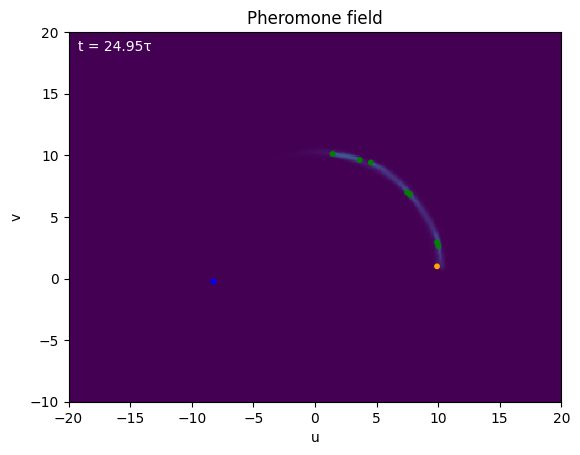

In [78]:
ani = field.animate(steps=500, agents=agents, interval=50, sim=sim)
ani.save("pheromone.mp4", writer="ffmpeg", fps=20)